In [20]:
from symred.projection import (
    S3_projection, QubitTapering, CS_VQE_LW, CS_VQE,
    StabilizerIdentification, ObservableBiasing, stabilizer_walk
)
from symred.symplectic import *
from symred.utils import exact_gs_energy
from symred.utils import gf2_gaus_elim, gf2_basis_for_gf2_rref
from symred.chem import geometry_from_pubchem, MoleculeBuilder
from matplotlib import pyplot as plt
from functools import reduce
import json

import sys
sys.path.append( '../../CS-VQE' )
from utils.cs_vqe_tools_original import *

In [21]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
with open('data/score_data.json', 'r') as infile:
    scoring_data = json.load(infile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

In [22]:
molecules = [speciesname for speciesname in scoring_data if 
             scoring_data[speciesname]['n_qubits_post_taper']<=14 and speciesname.find('+')==-1]
molecules

['H2O_STO-3G_SINGLET',
 'BeH2_STO-3G_SINGLET',
 'Be_STO-3G_SINGLET',
 'HF_STO-3G_SINGLET',
 'LiH_STO-3G_SINGLET',
 'NH3_STO-3G_SINGLET']

In [25]:
def get_score_vs_error(cs_vqe_obj, S, max_sim_q=15):
    stab_score  = cs_vqe_obj.basis_score(S)
    ham_cs = cs_vqe_obj.project_onto_subspace(S, enforce_clique_operator=False)
    n_qubits = ham_cs.n_qubits
    if i<=max_sim_q:
        matrix = ham_cs.to_sparse_matrix
        cs_vqe_energy = exact_gs_energy(matrix)[0]
        #error  = energy-molecule.fci_energy
    else:
        cs_vqe_energy = None
    
    return stab_score, cs_vqe_energy

In [43]:
stabilizer_identification_comparision = {}

for speciesname in molecules:
    print(speciesname)
    # build the molecule
    mol_data = molecule_geometries[speciesname]
    atoms  = mol_data['atoms']
    coords = mol_data['coords']
    geometry = list(zip(atoms, coords))
    molecule = MoleculeBuilder(geometry=geometry, charge=0, basis='STO-3G', spin=0, run_fci=True, print_info=False)
    
    # taper the Hamiltonian
    taper_hamiltonian = QubitTapering(molecule.H_q)
    hf_array = molecule.H_fermion.hf_comp_basis_state
    taper_hamiltonian.stabilizers.update_sector(hf_array)
    ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
    ucc_tap = taper_hamiltonian.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
    hf_tapered = taper_hamiltonian.tapered_ref_state
    
    # perform legacy CS-VQE calculations
    H = ham_tap.to_dictionary
    H_noncon = greedy_dfs(H, cutoff=10)[-1]
    H_noncon = {P:H[P] for P in H_noncon}
    nc_legacy, energies_legacy, errors_legacy, order_legacy = csvqe_approximations_heuristic(
        H, H_noncon, ham_tap.n_qubits, molecule.fci_energy)
    
    # initiate stabilizer identification classes
    Hc_stabilizers = StabilizerIdentification(ham_tap)
    CC_stabilizers = StabilizerIdentification(ucc_tap)
    HL_gap = np.where(hf_tapered==0)[0][0]-.5
    ham_biasing = ObservableBiasing(base_operator=ham_tap, HOMO_LUMO_gap=HL_gap)
    
    # build CS-VQE model
    cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
    
    data = {'n_sim_qubits':[],
           'stab_score_Hc':[],
           'stab_score_CC':[],
           'stab_score_HL':[],
           'cs_vqe_nrg_Hc':[],
           'cs_vqe_nrg_CC':[],
           'cs_vqe_nrg_HL':[],
           'cs_vqe_legacy':energies_legacy}

    for i in range(1, ham_tap.n_qubits):
        print(i)
        data['n_sim_qubits'].append(i)
        # by Hc
        S_Hc = Hc_stabilizers.symmetry_basis_by_subspace_dimension(i)
        stab_score_Hc, energy_Hc = get_score_vs_error(cs_vqe, S_Hc)
        data['stab_score_Hc'].append(stab_score_Hc)
        data['cs_vqe_nrg_Hc'].append(energy_Hc)

        # by CC
        S_CC = CC_stabilizers.symmetry_basis_by_subspace_dimension(i)
        stab_score_CC, energy_CC = get_score_vs_error(cs_vqe, S_CC)
        data['stab_score_CC'].append(stab_score_CC)
        data['cs_vqe_nrg_CC'].append(energy_CC)

        # by HOMO-LUMO biasing
        S_HL = stabilizer_walk(
                n_sim_qubits=i, 
                biasing_operator=ham_biasing, 
                cs_vqe_object=cs_vqe,
                #tapering_object=taper_hamiltonian,
                #reference_state=hf_array
            )
        stab_score_HL, energy_HL = get_score_vs_error(cs_vqe, S_HL)
        data['stab_score_HL'].append(stab_score_HL)
        data['cs_vqe_nrg_HL'].append(energy_HL)

    stabilizer_identification_comparision[speciesname] = {
            'n_qubits_pre_taper': int(molecule.n_qubits),
            'n_qubits_post_taper': int(ham_tap.n_qubits),
            'hf_energy': molecule.hf_energy,
            'mp2_energy': molecule.mp2_energy,
            'ccsd_energy': molecule.ccsd_energy,
            'fci_energy': molecule.fci_energy,
            'data':data
        }


H2O_STO-3G_SINGLET
1
2
3
4
5
6
7
8
9
BeH2_STO-3G_SINGLET
1
2
3
4
5
6
7
8
Be_STO-3G_SINGLET
1
2
3
4
HF_STO-3G_SINGLET
1
2
3
4
5
6
7
LiH_STO-3G_SINGLET
1
2
3
4
5
6
7
NH3_STO-3G_SINGLET
1
2
3
4
5
6
7
8
9
10
11
12


In [44]:
with open('data/stabilizer_identification_comparision.json', 'w') as outfile:
    json.dump(stabilizer_identification_comparision, outfile)

In [45]:
stabilizer_identification_comparision

{'H2O_STO-3G_SINGLET': {'n_qubits_pre_taper': 14,
  'n_qubits_post_taper': 10,
  'hf_energy': -74.96203967838726,
  'mp2_energy': -74.99708201366201,
  'ccsd_energy': -75.01073164269077,
  'fci_energy': -75.01084664816948,
  'data': {'n_sim_qubits': [1, 2, 3, 4, 5, 6, 7, 8, 9],
   'stab_score_Hc': [0.004541720623409055,
    0.1167059264101885,
    0.17605982586301708,
    0.28054250723260904,
    0.4265562830101684,
    0.6359543257746115,
    0.6375831118526928,
    0.6401267955689275,
    0.9488140587074627],
   'stab_score_CC': [0.10762248516337039,
    0.18922447617696983,
    0.33421073417745323,
    0.5476101772171974,
    0.6863912747861368,
    0.893375600995969,
    0.9445615422885063,
    0.991053258513723,
    0.9947694589655967],
   'stab_score_HL': [0.018285178303618203,
    0.09995462359412036,
    0.1860983352311289,
    0.2764037320209151,
    0.3832531887069853,
    0.6359543257746115,
    0.9398673172211859,
    0.991053258513723,
    0.9947694589655967],
   'cs_vqe_n

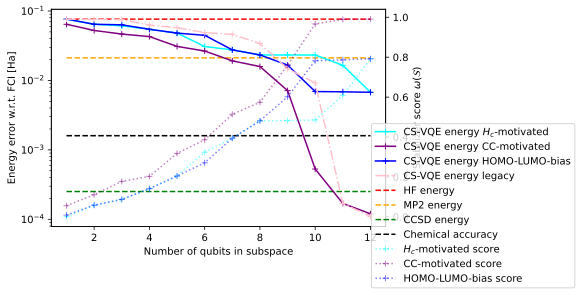

In [47]:
fig,energy_axis = plt.subplots()

speciesname = 'NH3_STO-3G_SINGLET'

X = stabilizer_identification_comparision[speciesname]['data']['n_sim_qubits']
Y_Hc = stabilizer_identification_comparision[speciesname]['data']['cs_vqe_nrg_Hc']
Y_CC = stabilizer_identification_comparision[speciesname]['data']['cs_vqe_nrg_CC']
Y_HL = stabilizer_identification_comparision[speciesname]['data']['cs_vqe_nrg_HL']
Y_legacy = stabilizer_identification_comparision[speciesname]['data']['cs_vqe_legacy']
Y_score_Hc = stabilizer_identification_comparision[speciesname]['data']['stab_score_Hc']
Y_score_CC = stabilizer_identification_comparision[speciesname]['data']['stab_score_CC']
Y_score_HL = stabilizer_identification_comparision[speciesname]['data']['stab_score_HL']
fci_energy = stabilizer_identification_comparision[speciesname]['fci_energy']

energy_axis.plot(X, Y_Hc-fci_energy, color='cyan', marker='+', label='CS-VQE energy $H_c$-motivated')
energy_axis.plot(X, Y_CC-fci_energy, color='purple', marker='+', label='CS-VQE energy CC-motivated')
energy_axis.plot(X, Y_HL-fci_energy, color='blue', marker='+', label='CS-VQE energy HOMO-LUMO-bias')
energy_axis.plot(X, Y_legacy[1:-1]-fci_energy, color='pink', marker='+', label='CS-VQE energy legacy', ls='-.')

energy_axis.hlines(molecule.hf_energy-molecule.fci_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(molecule.mp2_energy-molecule.fci_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(molecule.ccsd_energy-molecule.fci_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

energy_axis.set_yscale('log')
energy_axis.set_ylabel('Energy error w.r.t. FCI [Ha]')
energy_axis.set_xlabel('Number of qubits in subspace')

score_axis = energy_axis.twinx()
score_axis.plot(X, Y_score_Hc, color='cyan', label='$H_c$-motivated score', marker='+', alpha=0.5, ls=':')
score_axis.plot(X, Y_score_CC, color='purple', label='CC-motivated score', marker='+', alpha=0.5, ls=':')
score_axis.plot(X, Y_score_HL, color='blue', label='HOMO-LUMO-bias score', marker='+', alpha=0.5, ls=':')

score_axis.set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

fig.legend(ncol=1, bbox_to_anchor=(1.35,0.5))
plt.show()